#### QAPP ID: I-CCED-0032994-QP-1-0
#### Author: Matthew Adams
#### Principal Investigator(s): Grace Patlewicz & Imran Shah
#### Last Modified MM DD 2022

### Notebook 0XXX: Multi-Task Learner Implementation


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import functools
import pandas as pd
import matplotlib.pyplot as plt
import sys
from box import Box
import deepchem as dc
user = 'madams01'
sys.path.append(f'/home/{user}/git_clones/copymltox/ml-tox/src')
from genra.rax.skl.cls import *
from sklearn.linear_model import LogisticRegression
from mltox.ml.ml_oop_classifiers import MLClassifiers
from mltox.db.mongo import *
from mltox.db.bc import *
from mltox.db.bio import *
from mltox.db.chm import *
import numpy
import random
import tensorflow as tf



2022-11-02 08:15:49.848148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-02 08:15:49.848200: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-02 08:15:49.884338: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-02 08:15:51.765940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-02 08:15:51.766319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [2]:
DB5 = openMongo(db='genra_dev_v5',host='pb.epa.gov',auth=True)

In [3]:
def vote(x):
    votes = list(x)
    if sum(votes)/len(votes) < 0.5:
        return 0
    else:
        return 1

def get_multitask_data(Assay_list):
    dfs = []
    asy_list = []
    for asy in Assay_list:
        try:
            Y1 = get_bio_activities(
                                    DB5.toxcast_fp,
                                    assay=asy,
                                    fld='assay_component_name',
                                    h0='0.7',
                                    val='B1.1',
                                    full=False
                                    )
            Y = Y1.groupby('dsstox_sid').agg(lambda x: vote(x)).reset_index()
            if Y.shape[0] > 0:
                 dfs.append(Y)
                 asy_list.append(asy)
        except:
            pass
    print('loop done')
    df_final = functools.reduce(lambda left,right: pd.merge(left,right,on='dsstox_sid',how='outer'), dfs).fillna(-1)

    cols = [asy for asy in asy_list]
    cols.insert(0,'dsstox_sid')
    Y1 = df_final[cols]

    X1 = get_chm_FP(
                    Y1.dsstox_sid,
                    DB5.chms_fp,
                    fp='mrgn',
                    fill=np.uint(0)
                    )

    SID = set(X1.dsstox_sid.to_list()).intersection(Y1.dsstox_sid)

    XY1 = X1.merge(Y1,on='dsstox_sid',how='right')
    XY1 = XY1[XY1.dsstox_sid.isin(SID)]
    
    X = XY1[X1.columns[X1.columns!='dsstox_sid']]
    Y = XY1[Y1.columns[Y1.columns!='dsstox_sid']]

    return X,Y


In [4]:
def load_data(assay_list,seed=42,cv=False,k=5):
    X,Y =   get_multitask_data(assay_list)

    dataset = dc.data.NumpyDataset(X,Y) 

    splitter = dc.splits.RandomStratifiedSplitter()

    mydir = '/home/madams01/git_clones/copymltox/ml-tox/notebooks/ma'

    if cv:
        dir_lst = [f'{mydir}/tmp/k{i}' for i in range(2*k)]
        datasets = splitter.k_fold_split(dataset,k=k,seed=seed,directories=dir_lst)
        return datasets
        
    datasets = splitter.train_test_split(dataset,frac_train=0.8,seed=seed)
    return [datasets]

In [5]:
def multi_task_evaluate(Assay_list,dataset,seed):
    splitter = dc.splits.RandomStratifiedSplitter()
    train_dataset,test_dataset = splitter.train_test_split(dataset,frac_train=0.8,seed=seed)
    n_tasks = dataset.y.shape[1]
    n_features = dataset.X.shape[1]
    model = dc.models.RobustMultitaskClassifier(n_tasks, n_features)
    model.fit(train_dataset)
    y_true = test_dataset.y
    y_pred = model.predict(test_dataset)
    metric = dc.metrics.roc_auc_score
    scores = []
    for i in range(n_tasks):
        score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
        scores.append([Assay_list[i],score])
    return scores

In [6]:
Assay_list = get_bio_assays(DB5.toxcast_assays)
prefixes = set([i.split('_')[0] for i in Assay_list])
subset_assays = [i for i in Assay_list if i.startswith('ATG_')]

test_set = subset_assays

x, y= get_multitask_data(test_set)



loop done


In [7]:
random.seed(42)
def assign_missing_values(X,counts):
    p_hit = counts[1] /(counts[0] + counts[1])
    p_nohit = 1 - p_hit
    if X == -1:
         X = random.choices((1,0),weights=[p_hit,p_nohit],k=1)[0]
    return X

def replace_missing_data(y,mode):
    y_new = y.loc[:, ~(y== -1.0).sum()>-y.shape[0]*0.1]   #drop columns with > 10% missing data
    if mode == 'impute':
        for column in y_new:
            if (y_new[column]==-1).any() and not (y_new[column]==-1).all():
                counts = y_new[column].value_counts()
                y_new[column] = y_new[column].apply(lambda x: assign_missing_values(x,counts))
    elif mode == 'fill':
        y_new = y_new.replace(-1,0)
    elif mode == None:
        pass
    return y_new.apply(np.int64)

In [8]:
y_new = replace_missing_data(y,'fill')
y_new

,ATG_AP_1_CIS,ATG_AP_2_CIS,ATG_AR_TRANS,ATG_Ahr_CIS,ATG_BRE_CIS,ATG_CAR_TRANS,ATG_CMV_CIS,ATG_CRE_CIS,ATG_C_EBP_CIS,ATG_DR4_LXR_CIS,...,ATG_Sp1_CIS,ATG_TAL_CIS,ATG_TA_CIS,ATG_TCF_b_cat_CIS,ATG_TGFb_CIS,ATG_THRa1_TRANS,ATG_VDRE_CIS,ATG_VDR_TRANS,ATG_Xbp1_CIS,ATG_p53_CIS
0,0,1,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,1,0,0,1,1,1,0,...,1,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3761,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3763,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/home/madams01/anaconda3/envs/tflow/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 73.5, 'ASSAY')

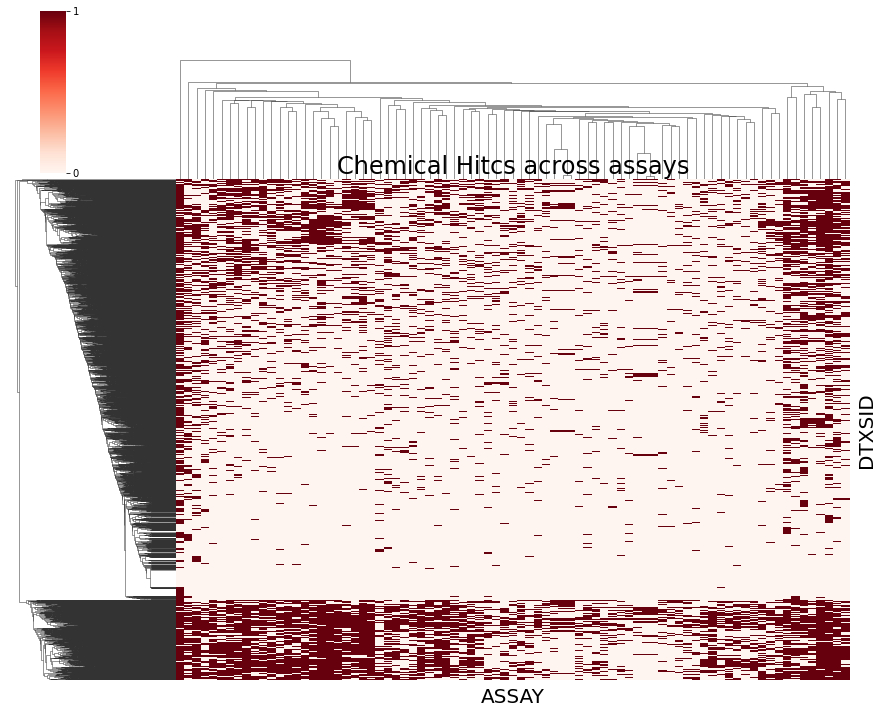

In [9]:
import seaborn as sns
g = sns.clustermap(
        y_new,
        figsize=(12, 9),
        row_cluster=True,
        col_cluster=True,
        xticklabels=False,
        yticklabels=False,
        cmap="Reds",
        cbar_pos=(0.05, 0.8, .03, .25),
        cbar_kws={"ticks":[-1,0,1]}
    )

ax = g.ax_heatmap
ax.set_title('Chemical Hitcs across assays',fontsize=24)
ax.set_ylabel('DTXSID',fontsize=20)
ax.set_xlabel('ASSAY',fontsize=20)

(0.0, 50.0)

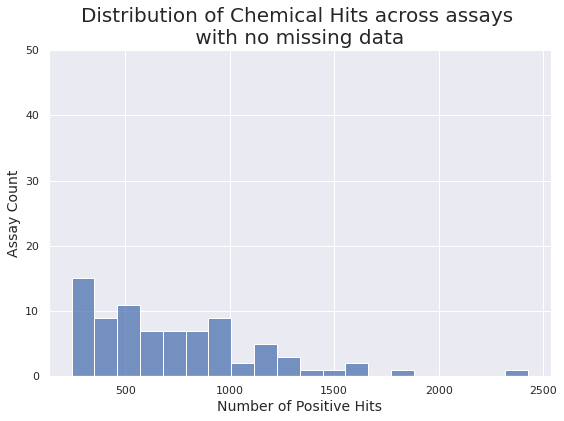

In [10]:
hits = (y_new==1).sum()
sns.set(rc={"figure.figsize":(9, 6)}) 

g = sns.histplot(hits,bins=20)
g.set_xlabel('Number of Positive Hits',fontsize=14)
g.set_ylabel('Assay Count',fontsize=14)
g.set_title('Distribution of Chemical Hits across assays \n with no missing data ',fontsize=20)
g.set_ylim(0,50)

In [11]:
tf.random.set_seed(0)
np.random.seed(0)
random.seed(0)
def eval_assays(x,y,seed):
    dataset = dc.data.NumpyDataset(x,y) 
    Assay_list = y.columns.tolist()
    splitter = dc.splits.RandomStratifiedSplitter()
    train_dataset,test_dataset = splitter.train_test_split(dataset,frac_train=0.8,seed=seed)
    n_tasks = dataset.y.shape[1]
    n_features = dataset.X.shape[1]
    model = dc.models.RobustMultitaskClassifier(n_tasks, n_features)
    model.fit(train_dataset)
    y_true = test_dataset.y
    y_pred = model.predict(test_dataset)
    metric = dc.metrics.roc_auc_score
    scores = []
    for i in range(n_tasks):
        score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
        scores.append([Assay_list[i],score])
    return scores


In [12]:
tf.random.set_seed(0)
np.random.seed(0)
random.seed(0)
import os

def eval_assays_sub(x,y,subsample=False,subsample_fraction=0.8,seed=0):
    dataset = dc.data.NumpyDataset(x,y) 
    Assay_list = y.columns.tolist()
    splitter = dc.splits.RandomStratifiedSplitter()
    if subsample:
        dataset, _, _ = splitter.train_valid_test_split(dataset,frac_train=subsample_fraction,frac_valid=0.0,frac_test=0.0,seed=seed,
                                            test_dir=f'{os.getcwd()}/tmp_test_data/',
                                            train_dir=f'{os.getcwd()}/tmp_train_data/',
                                            valid_dir=f'{os.getcwd()}/tmp_valid_data/')
    print(dataset.X.shape)
    train_dataset, _ ,test_dataset = splitter.train_valid_test_split(dataset,frac_train=0.8,frac_test=0.2,frac_valid=0.0,seed=seed,               
                                                            test_dir=f'{os.getcwd()}/tmp_test_data/',
                                                            train_dir=f'{os.getcwd()}/tmp_train_data/',
                                                            valid_dir=f'{os.getcwd()}/tmp_valid_data/')
    n_tasks = dataset.y.shape[1]
    n_features = dataset.X.shape[1]
    model = dc.models.RobustMultitaskClassifier(n_tasks, n_features,layer_sizes=[500],model_dir=f'{os.getcwd()}/tmp_mtl_model/')
    model.fit(train_dataset)
    y_true = test_dataset.y
    y_pred = model.predict(test_dataset)
    metric = dc.metrics.roc_auc_score
    scores = []
    for i in range(n_tasks):
        score = metric(dc.metrics.to_one_hot(y_true[:,i]), y_pred[:,i])
        scores.append([Assay_list[i],score])
    return scores

In [13]:
tf.random.set_seed(0)
np.random.seed(0)
random.seed(0)

data = []
for i in range(20):
    myscores = eval_assays_sub(x,y_new,subsample=True,subsample_fraction=1.0,seed=i)
    mydata = pd.DataFrame(myscores)
    data.append(mydata)
    

(3476, 2048)


2022-11-02 08:18:08.623114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-02 08:18:08.624056: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-02 08:18:08.624104: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (v2626umcth033.rtord.epa.gov): /proc/driver/nvidia/version does not exist


(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)
(3476, 2048)


In [14]:
df_tmp = pd.concat(data,axis=0)

df_tmp.to_pickle('mtl_models/bypass/mtl_bypass_500_1layer_20_100_data.pkl')

df_tmp.groupby(0).mean().mean()

1    0.632631
dtype: float64

In [39]:
data = []
for i in range(20):
    myscores = eval_assays(x,y_new,i)
    mydata = pd.DataFrame(myscores)
    data.append(mydata)

In [42]:
df_20 = pd.concat(data,axis=0).groupby(0).mean()

df_20.to_pickle('mtl_bypass_20.pkl')

(0.5, 0.8)

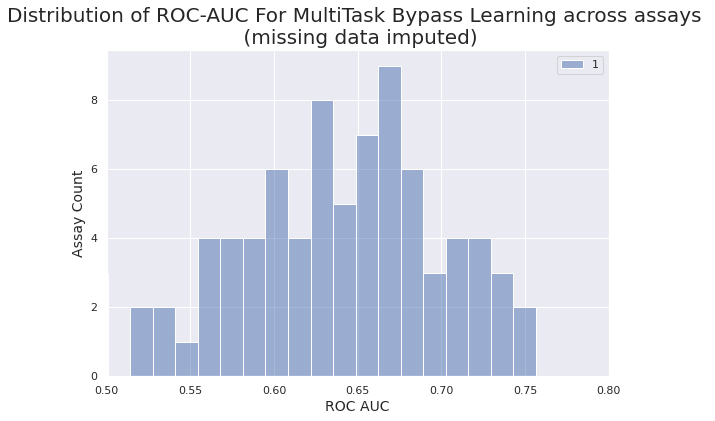

In [43]:
g = sns.histplot(df_20,bins=20)
g.set_xlabel('ROC AUC',fontsize=14)
g.set_ylabel('Assay Count',fontsize=14)
g.set_title('Distribution of ROC-AUC For MultiTask Bypass Learning across assays \n (missing data imputed)',fontsize=20)
g.set_xlim(0.5,0.8)

In [45]:
df_20.std()


1    0.063886
dtype: float64